In [221]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_score, recall_score, classification_report



In [222]:
df = pd.read_csv("./f1_race_data_2024_clean.csv")
df.head()


,Year,Round,EventName,Driver,DriverNumber,Team,LapNumber,LapTimeSeconds,Position,TireAge,...,AirTemp,Humidity,Pressure,WindDirection,WindSpeed,Rainfall,GapAhead,GapBehind,SafetyCar,PitThisLap
0,2024,1,Bahrain Grand Prix,ALB,23,Williams,1.0,103.888,11.0,1.0,...,18.2,49.0,1017.2,58,1.5,False,0.403,0.461,0,0
1,2024,1,Bahrain Grand Prix,ALB,23,Williams,2.0,98.826,11.0,2.0,...,18.3,49.0,1017.0,33,1.1,False,0.137,0.085,0,0
2,2024,1,Bahrain Grand Prix,ALB,23,Williams,3.0,98.507,11.0,3.0,...,18.3,49.0,1017.0,32,1.0,False,0.076,-0.108,0,0
3,2024,1,Bahrain Grand Prix,ALB,23,Williams,4.0,98.422,11.0,4.0,...,18.3,49.0,1017.0,24,0.9,False,0.112,0.075,0,0
4,2024,1,Bahrain Grand Prix,ALB,23,Williams,5.0,98.509,11.0,5.0,...,18.3,50.0,1017.1,40,1.5,False,0.188,0.067,0,0


In [223]:
df = df.sort_values(["Year", "Round", "Driver", "LapNumber"])
df["LapTimeDiff"] = df.groupby(["Year", "Round", "Driver"])["LapTimeSeconds"].diff().fillna(0)

In [224]:
numeric = [
    "LapTimeSeconds", "LapTimeDiff", "TireAge", "Position",
    "TrackTemp", "AirTemp", "Humidity", "Pressure",
    "WindSpeed", "Rainfall", "GapAhead", "GapBehind",
    "LapNumber", "Stint"
]

# Categorical: Compound
compound_dummies = pd.get_dummies(df["Compound"], prefix="Compound")
df = pd.concat([df, compound_dummies], axis=1)

df["SafetyCar"] = df["SafetyCar"].astype(int)

feature_cols = numeric + ["SafetyCar"] + list(compound_dummies.columns)
target_col = "PitThisLap"


In [225]:
group_cols = ["Year", "Round", "Driver"]

X_all = []
y_all = []

for _, g in df.groupby(group_cols):
    X_all.append(g[feature_cols].values.astype("float32"))
    y_all.append(g[target_col].values.astype("float32"))


In [226]:
from sklearn.model_selection import train_test_split
import numpy as np

indices = np.arange(len(X_all))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

def select(idx):
    return [X_all[i] for i in idx], [y_all[i] for i in idx]

X_train_raw, y_train = select(train_idx)
X_val_raw, y_val = select(val_idx)
X_test_raw, y_test = select(test_idx)


In [227]:
from sklearn.preprocessing import StandardScaler
import numpy as np

scaler = StandardScaler()

train_stack = np.vstack(X_train_raw)

scaler.fit(train_stack[:, :len(numeric)])


StandardScaler()

In [228]:
def apply_scaler(seqs):
    scaled = []
    for seq in seqs:
        X_num = scaler.transform(seq[:, :len(numeric)])
        X_rest = seq[:, len(numeric):]
        scaled.append(np.hstack([X_num, X_rest]))
    return scaled

X_train = apply_scaler(X_train_raw)
X_val = apply_scaler(X_val_raw)
X_test = apply_scaler(X_test_raw)


In [229]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

class PitStopSequenceDataset(Dataset):
    def __init__(self, X_list, y_list):
        self.X = X_list
        self.y = y_list
    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, idx):
        return (
            torch.tensor(self.X[idx], dtype=torch.float32),
            torch.tensor(self.y[idx], dtype=torch.float32),
            self.X[idx].shape[0]
        )


In [230]:
def collate_fn(batch):
    seqs, targets, lengths = zip(*batch)
    lengths = torch.tensor(lengths, dtype=torch.long)

    batch_size = len(seqs)
    max_len = lengths.max().item()
    feat_dim = seqs[0].shape[1]

    Xpad = torch.zeros(batch_size, max_len, feat_dim, dtype=torch.float32)
    ypad = torch.zeros(batch_size, max_len, dtype=torch.float32)
    mask = torch.zeros(batch_size, max_len, dtype=torch.bool)

    for i, (X, y, L) in enumerate(zip(seqs, targets, lengths)):
        # X, y are already tensors from the Dataset
        L = int(L.item())  # or just int(L)
        Xpad[i, :L] = X[:L]
        ypad[i, :L] = y[:L]
        mask[i, :L] = True

    return Xpad, ypad, mask, lengths




In [231]:
train_ds = PitStopSequenceDataset(X_train, y_train)
val_ds   = PitStopSequenceDataset(X_val, y_val)
test_ds  = PitStopSequenceDataset(X_test, y_test)

train_dl = DataLoader(train_ds, batch_size=32, shuffle=True,  collate_fn=collate_fn)
val_dl   = DataLoader(val_ds,   batch_size=32, shuffle=False, collate_fn=collate_fn)
test_dl  = DataLoader(test_ds,  batch_size=32, shuffle=False, collate_fn=collate_fn)


In [232]:
class PitStopLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, num_layers=1, dropout=0.0):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
        )
        self.fc = nn.Linear(hidden_dim, 1)

    def forward(self, x, lengths):
        packed = nn.utils.rnn.pack_padded_sequence(
            x, lengths.cpu(), batch_first=True, enforce_sorted=False
        )
        packed_out, _ = self.lstm(packed)
        out, _ = nn.utils.rnn.pad_packed_sequence(packed_out, batch_first=True)
        logits = self.fc(out).squeeze(-1)  
        return logits


In [233]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
input_dim = X_train[0].shape[1]

model = PitStopLSTM(
    input_dim=input_dim,
    hidden_dim=128,
    num_layers=2,
    dropout=0.2,
).to(device)





In [234]:
pos = sum(y.sum() for y in y_train)          
neg = sum((1 - y).sum() for y in y_train)    

criterion = nn.BCEWithLogitsLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)





In [235]:
X_train_flat = np.vstack(X_train)
y_train_flat = np.concatenate(y_train)

X_test_flat = np.vstack(X_test)
y_test_flat = np.concatenate(y_test)

from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(max_iter=1000, class_weight="balanced")
lr.fit(X_train_flat, y_train_flat)

lr_probs = lr.predict_proba(X_test_flat)[:, 1]


In [236]:
print("LR ROC-AUC:", roc_auc_score(y_test_flat, lr_probs))
print("LR PR-AUC:", average_precision_score(y_test_flat, lr_probs))


LR ROC-AUC: 0.9236245954692557
LR PR-AUC: 0.23310962045636968


In [237]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0

    for X_batch, y_batch, mask, lengths in train_dl:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask    = mask.to(device)
        lengths_cpu = lengths.cpu()

        optimizer.zero_grad()

        logits = model(X_batch, lengths_cpu)   

        loss = criterion(logits[mask == 1], y_batch[mask == 1])
        loss.backward()
        optimizer.step()

        train_loss += loss.item()



In [238]:
lstm_probs, lstm_targets = [], []

model.eval()
with torch.no_grad():
    for X_batch, y_batch, mask, lengths in test_dl:

        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)
        mask    = mask.to(device)
        lengths_cpu = lengths.cpu()

        logits = model(X_batch, lengths_cpu)
        probs = torch.sigmoid(logits)

        lstm_probs.append(probs[mask].cpu().numpy())
        lstm_targets.append(y_batch[mask].cpu().numpy())

lstm_probs = np.concatenate(lstm_probs)
lstm_targets = np.concatenate(lstm_targets)


In [239]:
from sklearn.metrics import roc_auc_score

print("LSTM ROC-AUC:", roc_auc_score(lstm_targets, lstm_probs))


LSTM ROC-AUC: 0.39093851132686086


In [240]:
from sklearn.metrics import average_precision_score

print("LSTM PR-AUC:", average_precision_score(lstm_targets, lstm_probs))


LSTM PR-AUC: 0.02672944527021176


In [241]:
from sklearn.metrics import confusion_matrix

preds_05 = (lstm_probs > 0.5).astype(int)
print(confusion_matrix(lstm_targets, preds_05))


[[309   0]
 [ 10   0]]


In [242]:
from sklearn.metrics import precision_score, recall_score, f1_score

preds_09 = (lstm_probs > 0.9).astype(int)

print("Precision@0.9:", precision_score(lstm_targets, preds_09))
print("Recall@0.9:", recall_score(lstm_targets, preds_09))
print("F1@0.9:", f1_score(lstm_targets, preds_09))


Precision@0.9: 0.0
Recall@0.9: 0.0
F1@0.9: 0.0


/Users/sylvia/miniforge3/envs/ml/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


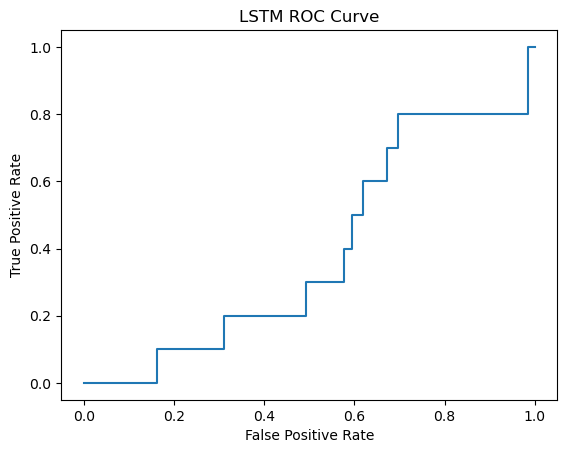

In [243]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(lstm_targets, lstm_probs)

plt.plot(fpr, tpr)
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("LSTM ROC Curve")
plt.show()


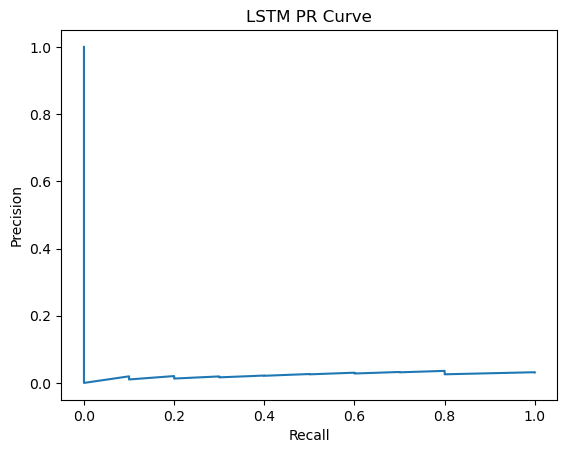

In [244]:
from sklearn.metrics import precision_recall_curve

prec, rec, _ = precision_recall_curve(lstm_targets, lstm_probs)

plt.plot(rec, prec)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("LSTM PR Curve")
plt.show()


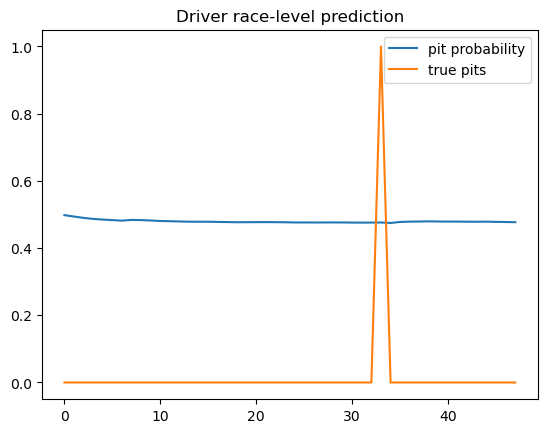

In [245]:
driver_idx = 0 
X_seq = X_test[driver_idx]
y_seq = y_test[driver_idx]

with torch.no_grad():
    logits = model(torch.tensor(X_seq).unsqueeze(0).to(device), 
                   torch.tensor([len(X_seq)]) )
    probs = torch.sigmoid(logits).cpu().numpy().flatten()

plt.plot(probs, label="pit probability")
plt.plot(y_seq, label="true pits")
plt.legend()
plt.title("Driver race-level prediction")
plt.show()


In [246]:
print(logits.shape, mask.shape)
print(np.mean(X_train[0], axis=0))
print(np.std(X_train[0], axis=0))



torch.Size([1, 48]) torch.Size([6, 57])
[ 0.07466999  0.01541528 -0.28179595 -0.91056156 -0.91891855 -0.92784995
 -0.9120233   0.92596424 -0.46204096  0.          0.15642422 -0.1078384
  0.10807122  0.3080904   0.          0.80701756  0.          0.19298245]
[0.6678109  0.797631   0.62062323 0.29581445 0.15026768 0.05590502
 0.10653274 0.07164051 0.85130715 0.         1.1434662  1.0604084
 1.0595038  1.0771588  0.         0.39463934 0.         0.39463934]
